In [72]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import calendar
from xgboost import XGBRegressor, plot_importance
import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import optuna

c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TARGET = 'percentage_docks_available'

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Baseline using Ridge and only the context variables

In [34]:
df_train = pd.read_csv('../datasets/train_dataset.csv')
df_test = pd.read_csv('../datasets/sub_dataset.csv',index_col = 0)
df_test = df_test.sort_index()
sample_sub = pd.read_csv('../data/submission_data/sample_submission.csv')

In [36]:
model = Ridge()

In [104]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [38]:
df_train = df_train[[col for col in df_train.columns if 'ctx' in col or col == TARGET]]

In [41]:
val_score = []
train_score = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train)):
    print(f'----------------FOLD {fold} --------------------------')
    X_train = df_train.loc[train_idx].copy()
    X_val = df_train.loc[val_idx].copy()

    y_train = X_train.pop(TARGET)
    y_val = X_val.pop(TARGET)

    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    train_rmse = RMSE(y_train, train_pred)
    val_rmse = RMSE(y_val, val_pred)

    print(f'Training error for fold {fold} is: {train_rmse}')
    print(f'Validation error for fold {fold} is: {val_rmse}')

    val_score.append(val_rmse)
    train_score.append(train_rmse)

print('-------------------------------------------------------------------')
print(f'AVERAGE Training error is: {np.mean(train_score)}')
print(f'AVERAGE Validation error: {np.mean(val_score)}')





----------------FOLD 0 --------------------------
Training error for fold 0 is: 0.11276031244745027
Validation error for fold 0 is: 0.11294478142886033
----------------FOLD 1 --------------------------
Training error for fold 1 is: 0.11280151001250388
Validation error for fold 1 is: 0.11277991447337024
----------------FOLD 2 --------------------------
Training error for fold 2 is: 0.11279015145563287
Validation error for fold 2 is: 0.1128253844767103
----------------FOLD 3 --------------------------
Training error for fold 3 is: 0.11279529629433122
Validation error for fold 3 is: 0.11280479793114614
----------------FOLD 4 --------------------------
Training error for fold 4 is: 0.11283831424724976
Validation error for fold 4 is: 0.11263253173652477
-------------------------------------------------------------------
AVERAGE Training error is: 0.1127971168914336
AVERAGE Validation error: 0.11279748200932235


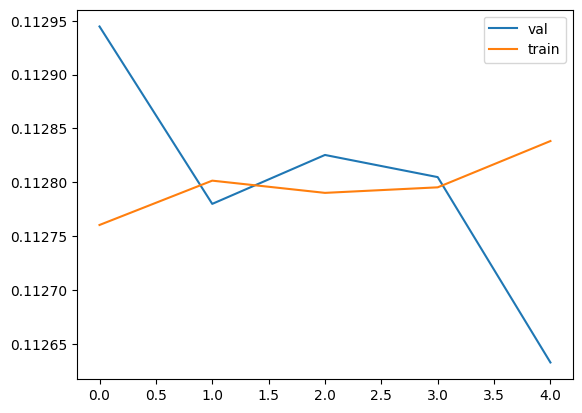

In [43]:
plt.figure()
plt.plot(val_score, label = 'val')
plt.plot(train_score, label = 'train')
plt.legend()

In [44]:
y = df_train.pop(TARGET)

In [54]:
model.fit(df_train, y)

Ridge()

In [55]:
test_preds = model.predict(df_test[[col for col in df_train.columns if 'ctx' in col or col == TARGET]])

In [56]:
sample_sub['percentage_docks_available'] = test_preds

In [57]:
sample_sub.to_csv('BASELINE_ridge_with_ctx.csv', index = None)

Kaggle LB score: 0.12673

## xgboost wit CTX, meteo, and feature engineered temporal data

In [8]:
df_train = pd.read_csv('../datasets/train_dataset.csv')
df_test = pd.read_csv('../datasets/sub_dataset.csv',index_col = 0)
df_test = df_test.sort_index()
sample_sub = pd.read_csv('../data/submission_data/sample_submission.csv')

In [55]:
march_2023_dict = {}
for day in range(1, 32):
    weekday = calendar.weekday(2023, 3, day)
    march_2023_dict[day] = weekday

df_test['dayofweek'] = df_test.day.map(march_2023_dict)

In [252]:
df_train.columns

Index(['station_id', 'last_reported', 'num_bikes_available', 'is_installed',
       'is_renting', 'month', 'day', 'hour', 'year', 'dayofweek', 'ctx-4',
       'ctx-3', 'ctx-2', 'ctx-1', 'name', 'lat', 'lon', 'capacity', 'altitude',
       'percentage_docks_available', 'temp', 'humidity', 'windspeed', 'precip',
       'icon'],
      dtype='object')

In [9]:
def month_to_season(row):
    if row.month in [12,1,2]:
        return 'winter'
    elif row.month in [3, 4, 5]:
        return 'spring'
    elif row.month in [6,7,8]:
        return 'summer'
    elif row.month in [9,10,11]:
        return 'fall'
    else:
        raise ValueError('value outside of range 1-12')

In [10]:
def is_low(df):
    return df.hour.isin([22,23,0,1,2,3,4,5,6]).values

def is_peak(df):
    return df.hour.isin([16,17,18,19,20]).values

In [11]:
def preprocess(df):
    data = df.copy()
    data['season'] = data.apply(month_to_season, axis = 1)
    data['is_peak'] = is_peak(data)
    data['is_low'] = is_low(data)
    return data


In [109]:
class pdOneHotEncoder(OneHotEncoder):
    def __init__(self, cols: list):
        super().__init__(sparse_output = False)
        self.cols = cols
        
    def fit(self, X, y):
        super().fit(X[self.cols],y)
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_oh = super().transform(X_[self.cols])
        X_[self.get_feature_names_out()] = X_oh
        X_ = X_.drop(self.cols, axis = 1)
        return X_

In [17]:
ohe_cols = ['dayofweek', 'icon', 'season']
cols = [
    'dayofweek', 'ctx-4','ctx-3', 'ctx-2', 'ctx-1',
    'lat', 'lon','altitude','temp', 'humidity',
    'windspeed', 'precip','icon', 'season', 'is_peak', 'is_low'
    ]

In [258]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

mask = ((df_train.day.isin(list(range(17,32))) & (df_train.month == 3)) & (df_train.year == 2020) ) \
    | ((df_train.day.isin(list(range(0,22))) & (df_train.month == 4)) & (df_train.year == 2020) )

df_train = df_train[~mask][cols + [TARGET]]
df_train = df_train.reset_index(drop=True)
df_test = df_test[cols]

In [261]:
df_train

,dayofweek,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,temp,humidity,windspeed,precip,icon,season,is_peak,is_low,percentage_docks_available
0,2.0,0.474638,0.507246,0.570652,0.617754,41.397978,2.180107,16.0,39.4,88.17,6.8,0.0,clear-night,winter,False,True,0.679348
1,2.0,0.324713,0.206897,0.037356,0.080460,41.395488,2.177198,17.0,39.4,88.17,6.8,0.0,clear-night,winter,False,True,0.169540
2,2.0,0.349206,0.226190,0.281746,0.246032,41.393317,2.181248,8.0,39.4,88.17,6.8,0.0,clear-night,winter,False,True,0.261905
3,2.0,0.168803,0.200855,0.230769,0.224359,41.391429,2.180569,10.0,39.4,88.17,6.8,0.0,clear-night,winter,False,True,0.222222
4,2.0,0.287037,0.256173,0.172840,0.185185,41.388885,2.183290,6.0,39.4,88.17,6.8,0.0,clear-night,winter,False,True,0.206790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424639,1.0,0.850000,0.759524,0.700000,0.640476,41.380641,2.167161,10.0,53.6,72.03,5.9,0.0,partly-cloudy-day,winter,False,False,0.519048
2424640,1.0,0.541818,0.338462,0.110000,0.066667,41.386961,2.182017,5.0,53.6,72.03,5.9,0.0,partly-cloudy-day,winter,False,False,0.206667
2424641,1.0,0.526316,0.574561,0.692982,0.929825,41.390530,2.190634,5.0,53.6,72.03,5.9,0.0,partly-cloudy-day,winter,False,False,0.995614
2424642,1.0,0.282051,0.282051,0.288462,0.331197,41.388997,2.192328,5.0,53.6,72.03,5.9,0.0,partly-cloudy-day,winter,False,False,0.337607


In [262]:
val_score = []
train_score = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train)):
    print(f'----------------FOLD {fold} --------------------------')
    X_train = df_train.loc[train_idx].copy()
    X_val = df_train.loc[val_idx].copy()

    y_train = X_train.pop(TARGET)
    y_val = X_val.pop(TARGET)

    ohe = pdOneHotEncoder(cols = ohe_cols)
    model = XGBRegressor()

    X_train_proc = ohe.fit_transform(X_train, y_train)
    X_val_proc = ohe.transform(X_val)

    model.fit(X_train_proc, y_train, eval_set = [(X_train_proc, y_train),(X_val_proc, y_val)], early_stopping_rounds = 10, verbose = 10)
    
    train_pred = model.predict(X_train_proc)
    val_pred = model.predict(X_val_proc)

    train_rmse = RMSE(y_train, train_pred)
    val_rmse = RMSE(y_val, val_pred)

    print(f'Training error for fold {fold} is: {train_rmse}')
    print(f'Validation error for fold {fold} is: {val_rmse}')

    val_score.append(val_rmse)
    train_score.append(train_rmse)

print('-------------------------------------------------------------------')
print(f'AVERAGE Training error is: {np.mean(train_score)}')
print(f'AVERAGE Validation error: {np.mean(val_score)}')





----------------FOLD 0 --------------------------


c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.22615	validation_1-rmse:0.22591
[10]	validation_0-rmse:0.10842	validation_1-rmse:0.10830
[20]	validation_0-rmse:0.10707	validation_1-rmse:0.10706
[30]	validation_0-rmse:0.10644	validation_1-rmse:0.10653
[40]	validation_0-rmse:0.10597	validation_1-rmse:0.10615
[50]	validation_0-rmse:0.10565	validation_1-rmse:0.10590
[60]	validation_0-rmse:0.10533	validation_1-rmse:0.10568
[70]	validation_0-rmse:0.10517	validation_1-rmse:0.10559
[80]	validation_0-rmse:0.10493	validation_1-rmse:0.10543
[90]	validation_0-rmse:0.10477	validation_1-rmse:0.10536
[99]	validation_0-rmse:0.10460	validation_1-rmse:0.10526
Training error for fold 0 is: 0.1046015220699287
Validation error for fold 0 is: 0.10526379742409729
----------------FOLD 1 --------------------------


c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.22608	validation_1-rmse:0.22604
[10]	validation_0-rmse:0.10837	validation_1-rmse:0.10875
[20]	validation_0-rmse:0.10708	validation_1-rmse:0.10757
[30]	validation_0-rmse:0.10630	validation_1-rmse:0.10686
[40]	validation_0-rmse:0.10589	validation_1-rmse:0.10654
[50]	validation_0-rmse:0.10553	validation_1-rmse:0.10625
[60]	validation_0-rmse:0.10527	validation_1-rmse:0.10606
[70]	validation_0-rmse:0.10501	validation_1-rmse:0.10588
[80]	validation_0-rmse:0.10481	validation_1-rmse:0.10577
[90]	validation_0-rmse:0.10457	validation_1-rmse:0.10561
[99]	validation_0-rmse:0.10439	validation_1-rmse:0.10549
Training error for fold 1 is: 0.10439464494619245
Validation error for fold 1 is: 0.10549211346611846
----------------FOLD 2 --------------------------


c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.22605	validation_1-rmse:0.22629
[10]	validation_0-rmse:0.10841	validation_1-rmse:0.10875
[20]	validation_0-rmse:0.10699	validation_1-rmse:0.10742
[30]	validation_0-rmse:0.10636	validation_1-rmse:0.10687
[40]	validation_0-rmse:0.10589	validation_1-rmse:0.10647
[50]	validation_0-rmse:0.10552	validation_1-rmse:0.10618
[60]	validation_0-rmse:0.10518	validation_1-rmse:0.10594
[70]	validation_0-rmse:0.10496	validation_1-rmse:0.10580
[80]	validation_0-rmse:0.10475	validation_1-rmse:0.10568
[90]	validation_0-rmse:0.10456	validation_1-rmse:0.10558
[99]	validation_0-rmse:0.10439	validation_1-rmse:0.10548
Training error for fold 2 is: 0.1043942050293477
Validation error for fold 2 is: 0.10548020947497522
----------------FOLD 3 --------------------------


c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.22608	validation_1-rmse:0.22623
[10]	validation_0-rmse:0.10840	validation_1-rmse:0.10841
[20]	validation_0-rmse:0.10698	validation_1-rmse:0.10706
[30]	validation_0-rmse:0.10637	validation_1-rmse:0.10655
[40]	validation_0-rmse:0.10586	validation_1-rmse:0.10614
[50]	validation_0-rmse:0.10556	validation_1-rmse:0.10595
[60]	validation_0-rmse:0.10531	validation_1-rmse:0.10577
[70]	validation_0-rmse:0.10505	validation_1-rmse:0.10561
[80]	validation_0-rmse:0.10486	validation_1-rmse:0.10551
[90]	validation_0-rmse:0.10460	validation_1-rmse:0.10534
[99]	validation_0-rmse:0.10447	validation_1-rmse:0.10527
Training error for fold 3 is: 0.10446577249209726
Validation error for fold 3 is: 0.10527286841357505
----------------FOLD 4 --------------------------


c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.22609	validation_1-rmse:0.22606
[10]	validation_0-rmse:0.10839	validation_1-rmse:0.10858
[20]	validation_0-rmse:0.10694	validation_1-rmse:0.10722
[30]	validation_0-rmse:0.10632	validation_1-rmse:0.10670
[40]	validation_0-rmse:0.10592	validation_1-rmse:0.10639
[50]	validation_0-rmse:0.10557	validation_1-rmse:0.10613
[60]	validation_0-rmse:0.10534	validation_1-rmse:0.10598
[70]	validation_0-rmse:0.10509	validation_1-rmse:0.10584
[80]	validation_0-rmse:0.10486	validation_1-rmse:0.10570
[90]	validation_0-rmse:0.10468	validation_1-rmse:0.10560
[99]	validation_0-rmse:0.10454	validation_1-rmse:0.10554
Training error for fold 4 is: 0.10454304208740173
Validation error for fold 4 is: 0.10553921256498816
-------------------------------------------------------------------
AVERAGE Training error is: 0.10447983732499358
AVERAGE Validation error: 0.10540964026875085


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

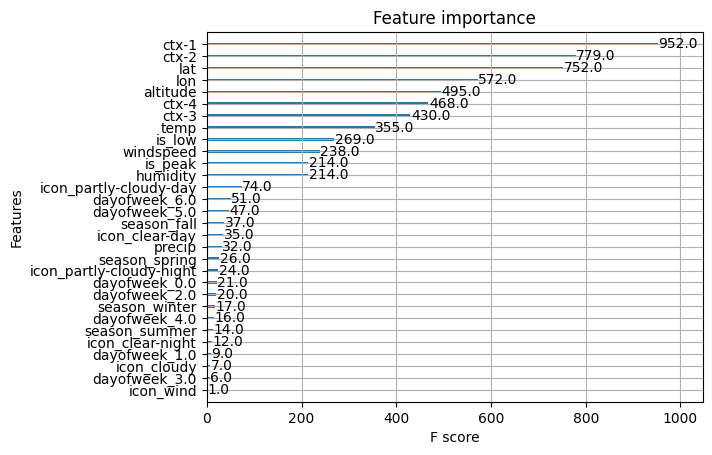

In [161]:
plot_importance(model)

In [163]:
y = df_train.pop(TARGET)

In [173]:
X_train_proc

,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,temp,humidity,windspeed,...,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_wind,season_fall,season_spring,season_summer,season_winter
0,0.474638,0.507246,0.570652,0.617754,41.397978,2.180107,16.0,39.4,88.17,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.324713,0.206897,0.037356,0.080460,41.395488,2.177198,17.0,39.4,88.17,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.349206,0.226190,0.281746,0.246032,41.393317,2.181248,8.0,39.4,88.17,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.168803,0.200855,0.230769,0.224359,41.391429,2.180569,10.0,39.4,88.17,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.287037,0.256173,0.172840,0.185185,41.388885,2.183290,6.0,39.4,88.17,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425800,0.850000,0.759524,0.700000,0.640476,41.380641,2.167161,10.0,53.6,72.03,5.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2425801,0.541818,0.338462,0.110000,0.066667,41.386961,2.182017,5.0,53.6,72.03,5.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2425802,0.526316,0.574561,0.692982,0.929825,41.390530,2.190634,5.0,53.6,72.03,5.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2425803,0.282051,0.282051,0.288462,0.331197,41.388997,2.192328,5.0,53.6,72.03,5.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [164]:
df_train = df_train[cols]

In [169]:
ohe = pdOneHotEncoder(cols = ohe_cols)
model = XGBRegressor()

In [171]:
X_train_proc = ohe.fit_transform(df_train, y)
X_test_proc = ohe.transform(df_test)

model.fit(X_train_proc, y)

preds = model.predict(X_test_proc)

c:\Users\alber\Documents\Bike_availability_prediction\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [172]:
sample_sub['percentage_docks_available'] = preds
sample_sub.to_csv('XGB_ctx_meteo_engineeredtime.csv', index = None)

Kaggle LB score: 0.13032  - Without removing bad days from 2020

# XGBoost with hyperparameter tuning

In [133]:
df_train = pd.read_csv('../datasets/train_dataset.csv')
df_test = pd.read_csv('../datasets/sub_dataset.csv',index_col = 0)
df_test = df_test.sort_index()
sample_sub = pd.read_csv('../data/submission_data/sample_submission.csv')

In [134]:
march_2023_dict = {}
for day in range(1, 32):
    weekday = calendar.weekday(2023, 3, day)
    march_2023_dict[day] = weekday

df_test['dayofweek'] = df_test.day.map(march_2023_dict)

In [135]:
ohe_cols = ['dayofweek', 'icon', 'season']
cols = [
    'dayofweek', 'ctx-4','ctx-3', 'ctx-2', 'ctx-1',
    'lat', 'lon','altitude','temp', 'humidity',
    'windspeed', 'precip','icon', 'season', 'is_peak', 'is_low'
    ]

In [136]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

mask = ((df_train.day.isin(list(range(17,32))) & (df_train.month == 3)) & (df_train.year == 2020) ) \
    | ((df_train.day.isin(list(range(0,22))) & (df_train.month == 4)) & (df_train.year == 2020) )

df_train = df_train[~mask][cols + [TARGET]]
df_train = df_train.reset_index(drop=True)
df_test = df_test[cols]

In [137]:
X_tr, X_vl = train_test_split(df_train, test_size=0.4, shuffle=True)

In [138]:
X_tr.reset_index(inplace=True, drop=True)

In [110]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1,7,2),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log = True),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'lambda': trial.suggest_float('lambda', 1e-3, 10, log = True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10, log = True)
    }
    val_score = []

    for train_idx, val_idx in kf.split(X_tr):
        X_train = X_tr.loc[train_idx].copy()
        X_val = X_tr.loc[val_idx].copy()

        y_train = X_train.pop(TARGET)
        y_val = X_val.pop(TARGET)

        ohe = pdOneHotEncoder(cols = ohe_cols)
        X_train_proc = ohe.fit_transform(X_train, y_train)
        X_val_proc = ohe.transform(X_val)

        model = XGBRegressor(**params)
        model.fit(X_train_proc, y_train, verbose = 0)
        
        train_pred = model.predict(X_train_proc)
        val_pred = model.predict(X_val_proc)

        val_rmse = RMSE(y_val, val_pred)

        val_score.append(val_rmse)
    
    return np.mean(val_score)


In [111]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-06-18 00:39:43,104] A new study created in memory with name: no-name-8a56d601-e6c6-45b3-9d36-360b427378d2
[I 2023-06-18 00:42:28,081] Trial 0 finished with value: 0.13273267295867658 and parameters: {'max_depth': 5, 'learning_rate': 0.01351487655927115, 'subsample': 0.8758223709120238, 'lambda': 0.34424485542474836, 'alpha': 0.007659008348767765}. Best is trial 0 with value: 0.13273267295867658.
[I 2023-06-18 00:46:23,488] Trial 1 finished with value: 0.297416407724665 and parameters: {'max_depth': 7, 'learning_rate': 0.0001741215226199136, 'subsample': 0.4004311154818849, 'lambda': 2.863467350928895, 'alpha': 0.32555577391142887}. Best is trial 0 with value: 0.13273267295867658.
[I 2023-06-18 00:48:35,917] Trial 2 finished with value: 0.28744573170722515 and parameters: {'max_depth': 5, 'learning_rate': 0.000577446221003767, 'subsample': 0.9611740489350096, 'lambda': 7.949660900169154, 'alpha': 1.0384690783192219}. Best is trial 0 with value: 0.13273267295867658.
[I 2023-06-18

KeyboardInterrupt: 

In [112]:
best_params = study.best_params
best_params

{'max_depth': 7,
 'learning_rate': 0.09975139933136541,
 'subsample': 0.631031319312395,
 'lambda': 0.002623757948208598,
 'alpha': 1.8613752484919097}

In [139]:
y = X_tr.pop(TARGET)

In [140]:
y_test = X_vl.pop(TARGET)

In [141]:
ohe = pdOneHotEncoder(ohe_cols)
X_proc = ohe.fit_transform(X_tr, y)
X_test = ohe.transform(X_vl)

In [142]:
model = XGBRegressor(**best_params)
model.fit(X_proc, y)
test_preds = model.predict(X_test)
test_rmse = RMSE(y_test, test_preds)
print(test_rmse)

0.10571633566506074


In [143]:
X_test['target'] = y_test
X_test['preds'] = test_preds
X_test['res'] = X_test['target'] - X_test['preds']

In [152]:
rep = X_test[['target', 'preds', 'res']]

In [155]:
rep[np.abs(rep.res) > 0.1].sort_values(by = 'res')

,target,preds,res
1982315,0.000000,0.941925,-0.941925
1707039,0.000000,0.940101,-0.940101
25859,0.000000,0.919835,-0.919835
918861,0.000000,0.909784,-0.909784
819758,0.047619,0.943147,-0.895528
...,...,...,...
988783,0.962963,0.053632,0.909331
1915809,0.995370,0.079729,0.915641
99732,0.962963,0.040581,0.922382
142970,1.000000,0.070982,0.929018


1982315

In [145]:
y = df_train.pop(TARGET)

In [148]:
X_sub = ohe.fit_transform(df_train, y)
X_sub = ohe.transform(df_test)

In [149]:
preds = model.predict(X_sub)

In [129]:
sample_sub['percentage_docks_available'] = preds
sample_sub.to_csv('XGB_with_tuning.csv', index = None)

# Dense NN

In [33]:
df_train = pd.read_csv('../datasets/train_dataset.csv')
df_test = pd.read_csv('../datasets/sub_dataset.csv',index_col = 0)
df_test = df_test.sort_index()
sample_sub = pd.read_csv('../data/submission_data/sample_submission.csv')

In [34]:
X_train = preprocess(df_train)

In [60]:
X_test = preprocess(df_test)

In [35]:
ohe = pdOneHotEncoder(cols = ohe_cols)

In [36]:
X_tr, X_vl = train_test_split(X_train, test_size = 0.4, shuffle = True)

In [37]:
y_train = X_tr.pop(TARGET)
X_tr = X_tr[cols]

y_val = X_vl.pop(TARGET)
X_vl = X_vl[cols]

In [39]:
X_tr = ohe.fit_transform(X_tr, y_train)
X_vl = ohe.transform(X_vl)

In [40]:
class BicingDataset(Dataset):

    def __init__(self, X, y):

        self.x_train = torch.tensor(X.values.astype('float32'), dtype=torch.float32)
        self.y_train = torch.tensor(y.values.astype('float32'), dtype = torch.float32).view(-1,1)

    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]



In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
train_ds = BicingDataset(X_tr, y_train)

In [44]:
test_ds = BicingDataset(X_vl, y_val)

In [45]:
train_loader = DataLoader(train_ds, batch_size=16384, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=16384, shuffle = False)

In [46]:
class DenseNetwork(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.bn1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        out = self.fc3(out)
        return out

In [47]:
model = DenseNetwork(32, 64, 32, 1)

In [48]:
model.to(device = device)

DenseNetwork(
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (relu1): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [50]:
criterion = nn.MSELoss()

In [51]:
for epoch in range(1):
    print(f"Starting epoch {epoch + 1}")
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device=device)
        target = target.to(device=device)
        
        #forward
        preds = model(data)
        loss = criterion(preds, target)

        #backward
        #set gradiets to zero for each batch
        optimizer.zero_grad()
        loss.backward()
        #gradient descent
        optimizer.step()

        #evaluation
        model.eval()
        test_loss = 0
        test_rmse = 0
        #turning of gradient tracking
        with torch.inference_mode(): 
            for batch, (test_data, test_target) in enumerate(test_loader):
               
                test_data = test_data.to(device = device)
                test_target = test_target.to(device = device)
                test_pred = model(test_data)

                loss = criterion(test_pred, test_target)
                test_loss += loss.item()
                # test_rmse += RMSE(test_target, test_pred)

            test_loss = test_loss / len(test_loader)
            # test_rmse = test_rmse / len(test_loader)
            if not batch_idx % 10:
                print(f"Evaluation at batch {batch_idx}")
                print(f"Test loss, MAE: {test_loss}")
                print(f"Test RMSE: {np.sqrt(2 * (test_loss**2))}")
            # print(f"Test RMSE: {test_rmse}")



Starting epoch 1
Evaluation at batch 0
Test loss, MAE: 0.5223763604958852
Test RMSE: 0.7387517336763779
Evaluation at batch 10
Test loss, MAE: 0.12899378364284833
Test RMSE: 0.18242475828953683
Evaluation at batch 20
Test loss, MAE: 0.08153246218959491
Test RMSE: 0.11530431380219669
Evaluation at batch 30
Test loss, MAE: 0.06348217551906904
Test RMSE: 0.08977735358801671


KeyboardInterrupt: 

In [63]:
X_test = torch.tensor(X_test.values.astype('float32'))

ValueError: could not convert string to float: 'C/ DIPUTACIÓ, 226'

In [61]:
X_test = X_test.to(device=device)

AttributeError: 'DataFrame' object has no attribute 'to'

In [407]:
sub_preds = model(X_test)

In [413]:
sub_preds

tensor([[0.4475],
        [0.2750],
        [0.4580],
        ...,
        [0.3932],
        [0.1702],
        [0.4995]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [414]:
sample_sub['percentage_docks_available'] = sub_preds.detach().cpu().numpy()

In [418]:
sample_sub.to_csv('DenseNeuralNetwork.csv', index = None)